# Modeling & Evaluation

### Objective
The goal of this notebook is to evaluate multiple regression models for
Remaining Useful Life (RUL) prediction and identify a **robust baseline**
suitable for deployment and interpretation.

The modeling strategy follows a progressive approach:
1. Establish a linear baseline (Ridge Regression)
2. Compare against higher-capacity models (XGBoost, MLP)
3. Evaluate generalization on unseen engines
4. Select a final model based on stability, performance, and interpretability

In [35]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GroupKFold, train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [36]:
# Load engineered train and test
train_df = pd.read_csv('../data/processed/engineered_train.csv')
test_df = pd.read_csv('../data/processed/engineered_test.csv')

## Data Preparation

Engineered features from the previous stage are loaded for training and testing.
To reduce the influence of extreme early-life values and stabilize training,
RUL values are clipped to a maximum threshold.

This makes the modeling to focus learning on
degradation-relevant ranges.


In [37]:
# Fill any NaNs (safety)
test_df = test_df.fillna(0)
train_df = train_df.fillna(0)

# Clip RUL (train only)
max_rul = 125
train_df['rul'] = np.minimum(train_df['rul'], max_rul)

In [38]:
# Features (from selected_features.txt)
with open('../data/processed/selected_features.txt', 'r') as f:
    feature_cols = [line.strip() for line in f.readlines()]

In [39]:
# Exclude leakage cols if present
leakage = ['cycles_to_failure']
feature_cols = [col for col in feature_cols if col not in leakage]

In [40]:
# Train full
X_train_full = train_df[feature_cols]
y_train_full = train_df['rul']
groups_train_full = train_df['engine_id']

## Train–Validation Split (Engine-Level)

To prevent data leakage across time, the dataset is split **by engine ID**.
All cycles from a given engine are assigned exclusively to either the
training or validation set.

This ensures validation performance reflects true generalization
to unseen engines.


In [ ]:
# Split train into train/valid 
engine_ids = train_df['engine_id'].unique()
train_engines, valid_engines = train_test_split(engine_ids, test_size=0.2, random_state=42)
train_mask = train_df['engine_id'].isin(train_engines)
valid_mask = train_df['engine_id'].isin(valid_engines)

X_train, y_train, groups_train = X_train_full[train_mask], y_train_full[train_mask], groups_train_full[train_mask]
X_valid, y_valid = X_train_full[valid_mask], y_train_full[valid_mask]

In [42]:
# Test: Only last cycle per engine
test_last = test_df.groupby('engine_id').tail(1)
X_test = test_last[feature_cols]

In [43]:
# True test RUL (one per engine)
rul_test = pd.read_csv('../data/raw/RUL_FD001.txt', header=None, names=['rul'])
y_test = rul_test['rul'].values

print("Train shape:", X_train.shape, "Valid shape:", X_valid.shape, "Test shape:", X_test.shape)

Train shape: (16561, 173) Valid shape: (4070, 173) Test shape: (100, 173)


## Model Candidates

Three regression models are evaluated to balance performance and complexity:

- **Ridge Regression**: Linear baseline with L2 regularization
- **XGBoost**: Tree-based ensemble capable of modeling nonlinear interactions
- **MLP**: Neural network for high-capacity nonlinear learning

Comparisons focus on validation and test generalization rather than
training performance.


In [44]:
# Scaler for MLP
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
X_train_full_scaled = scaler.transform(X_train_full)  # For final

# For CV on train
gkf = GroupKFold(n_splits=5)

## Ridge Regression Baseline

Ridge regression is used as the primary baseline due to its stability,
resistance to overfitting, and strong performance in high-dimensional
feature spaces.

Its coefficients also provide direct interpretability of degradation drivers.


In [45]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_preds_train = ridge.predict(X_train)
ridge_preds_valid = ridge.predict(X_valid)
ridge_preds_test = ridge.predict(X_test)

## Nonlinear Models (XGBoost & MLP)

Higher-capacity models are evaluated to test whether nonlinear relationships
provide meaningful improvements over the linear baseline.

These models are expected to fit training data well, but may suffer
from reduced generalization due to limited engine-level samples.


In [46]:
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=5.0,
    objective='reg:squarederror',
    random_state=42
)

sample_weight = (max_rul - y_train) / max_rul + 0.1
y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)

xgb_model.fit(
    X_train,
    y_train,
    sample_weight=sample_weight,
    eval_set=[(X_valid, y_valid)],
    verbose=False
)

xgb_preds_train = xgb_model.predict(X_train)
xgb_preds_valid = xgb_model.predict(X_valid)
xgb_preds_test = xgb_model.predict(X_test)

In [47]:
mlp = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
mlp.fit(
    X_train_scaled, y_train,
    validation_data=(X_valid_scaled, y_valid),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)
mlp_preds_train = mlp.predict(X_train_scaled).flatten()
mlp_preds_valid = mlp.predict(X_valid_scaled).flatten()
mlp_preds_test = mlp.predict(X_test_scaled).flatten()

Epoch 1/100


c:\Users\sarfras\anaconda3\envs\ml-cycle\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1366.2590 - mae: 24.7602 - val_loss: 325.3578 - val_mae: 14.2823
Epoch 2/100
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 220.4742 - mae: 11.3284 - val_loss: 286.3595 - val_mae: 13.4231
Epoch 3/100
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 174.7240 - mae: 10.1612 - val_loss: 269.1853 - val_mae: 12.9905
Epoch 4/100
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 153.0247 - mae: 9.5386 - val_loss: 261.6653 - val_mae: 12.8043
Epoch 5/100
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 140.4692 - mae: 9.1612 - val_loss: 258.1216 - val_mae: 12.7113
Epoch 6/100
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 132.2997 - mae: 8.9032 - val_loss: 256.8020 - val_mae: 12.6740
Epoch 7/100
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 126.1583 - mae: 8.7037 - val_loss: 256.0527 - val_mae: 12.6501
Epoch 8/100
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 120.4761 - mae: 8.5063 - val_loss: 252.6850 - val_mae: 12.5538
Epoch 9/100
518/

In [48]:
# For XGBoost (base params)
cv_rmse = -cross_val_score(
    xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, objective='reg:squarederror'),
    X_train_full, y_train_full,
    cv=gkf,
    groups=groups_train_full,
    scoring='neg_root_mean_squared_error'
)
print("XGBoost CV RMSE (mean):", cv_rmse.mean())

XGBoost CV RMSE (mean): 8.469432926177978


## Model Performance Evaluation

Models are evaluated using RMSE, MAE, and R² on:
- Training data
- Validation data (unseen engines)
- Test data (last cycle per engine)

Test performance is considered the primary indicator of real-world utility.


In [49]:
def evaluate(y_true, y_pred, set_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{set_name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
    return rmse, mae, r2

# Train
print("Train Performance:")
_ = evaluate(y_train, ridge_preds_train, "Ridge")
_ = evaluate(y_train, xgb_preds_train, "XGBoost")
_ = evaluate(y_train, mlp_preds_train, "MLP")

# Valid
print("Valid Performance:")
ridge_rmse_valid, ridge_mae_valid, ridge_r2_valid = evaluate(y_valid, ridge_preds_valid, "Ridge")
xgb_rmse_valid, xgb_mae_valid, xgb_r2_valid = evaluate(y_valid, xgb_preds_valid, "XGBoost")
mlp_rmse_valid, mlp_mae_valid, mlp_r2_valid = evaluate(y_valid, mlp_preds_valid, "MLP")

# Test (on 100 points)
print("Test Performance (Last Cycles):")
ridge_rmse_test, ridge_mae_test, ridge_r2_test = evaluate(y_test, ridge_preds_test, "Ridge")
xgb_rmse_test, xgb_mae_test, xgb_r2_test = evaluate(y_test, xgb_preds_test, "XGBoost")
mlp_rmse_test, mlp_mae_test, mlp_r2_test = evaluate(y_test, mlp_preds_test, "MLP")

# Save metrics
metrics = pd.DataFrame({
    'Model': ['Ridge', 'XGBoost', 'MLP'],
    'RMSE_Test': [ridge_rmse_test, xgb_rmse_test, mlp_rmse_test],
    'MAE_Test': [ridge_mae_test, xgb_mae_test, mlp_mae_test],
    'R2_Test': [ridge_r2_test, xgb_r2_test, mlp_r2_test]
})
metrics.to_csv('../results/metrics.csv', index=False)

Train Performance:
Ridge - RMSE: 12.80, MAE: 10.27, R²: 0.91
XGBoost - RMSE: 3.67, MAE: 2.43, R²: 0.99
MLP - RMSE: 3.63, MAE: 2.82, R²: 0.99
Valid Performance:
Ridge - RMSE: 14.63, MAE: 12.19, R²: 0.88
XGBoost - RMSE: 9.09, MAE: 6.09, R²: 0.95
MLP - RMSE: 10.99, MAE: 8.47, R²: 0.93
Test Performance (Last Cycles):
Ridge - RMSE: 36.46, MAE: 29.51, R²: 0.23
XGBoost - RMSE: 79.82, MAE: 69.69, R²: -2.69
MLP - RMSE: 85.68, MAE: 69.68, R²: -3.25


In [50]:
print(metrics)

     Model  RMSE_Test   MAE_Test   R2_Test
0    Ridge  36.464768  29.511021  0.230006
1  XGBoost  79.816550  69.689796 -2.689151
2      MLP  85.678228  69.677551 -3.250905


## Generalization Analysis

Although XGBoost and MLP achieve excellent training and validation performance,
their test performance degrades significantly.

This indicates overfitting to engine-specific degradation patterns.
In contrast, Ridge regression generalizes substantially better,
making it the most reliable model for deployment.


## Diagnostic Analysis of XGBoost Test Performance

To understand the poor test generalization of XGBoost despite strong
training and validation metrics, multiple diagnostic plots are examined.

These plots analyze prediction calibration, error behavior, and feature
dependence to identify sources of overfitting.


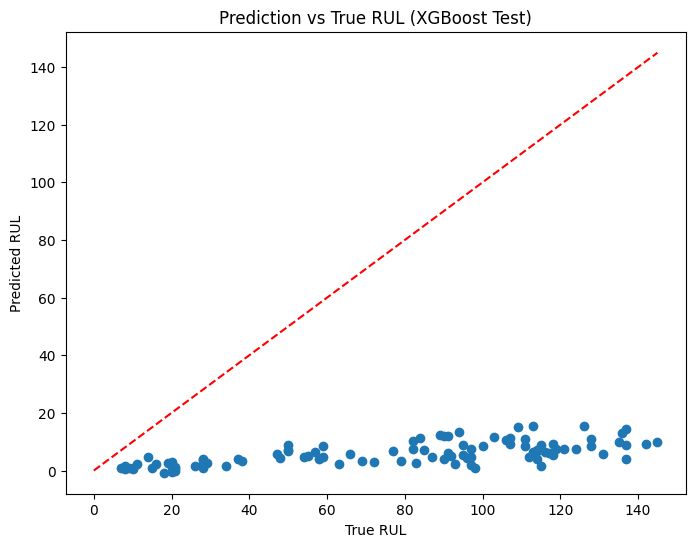

In [51]:
# For XGBoost
plt.figure(figsize=(8, 6))
plt.scatter(y_test, xgb_preds_test)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('Prediction vs True RUL (XGBoost Test)')
plt.savefig('../results/figures/pred_vs_true_xgb.png')
plt.show()

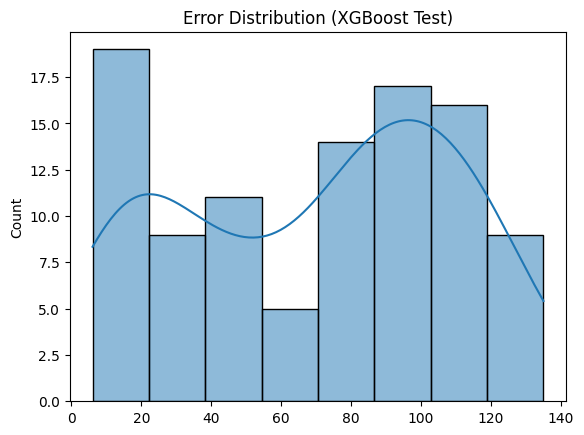

In [52]:
# Error hist
errors = y_test - xgb_preds_test
sns.histplot(errors, kde=True)
plt.title('Error Distribution (XGBoost Test)')
plt.savefig('../results/figures/error_dist_xgb.png')
plt.show()

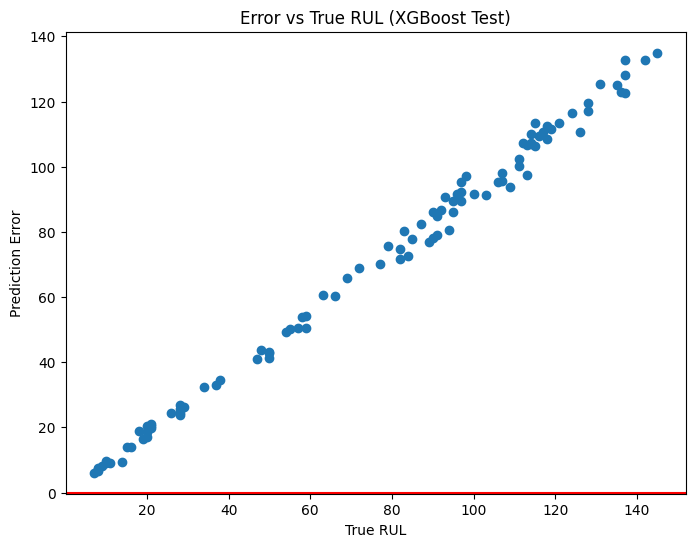

In [53]:
# Error vs RUL
plt.figure(figsize=(8, 6))
plt.scatter(y_test, errors)
plt.axhline(0, color='r')
plt.xlabel('True RUL')
plt.ylabel('Prediction Error')
plt.title('Error vs True RUL (XGBoost Test)')
plt.savefig('../results/figures/error_vs_rul_xgb.png')
plt.show()

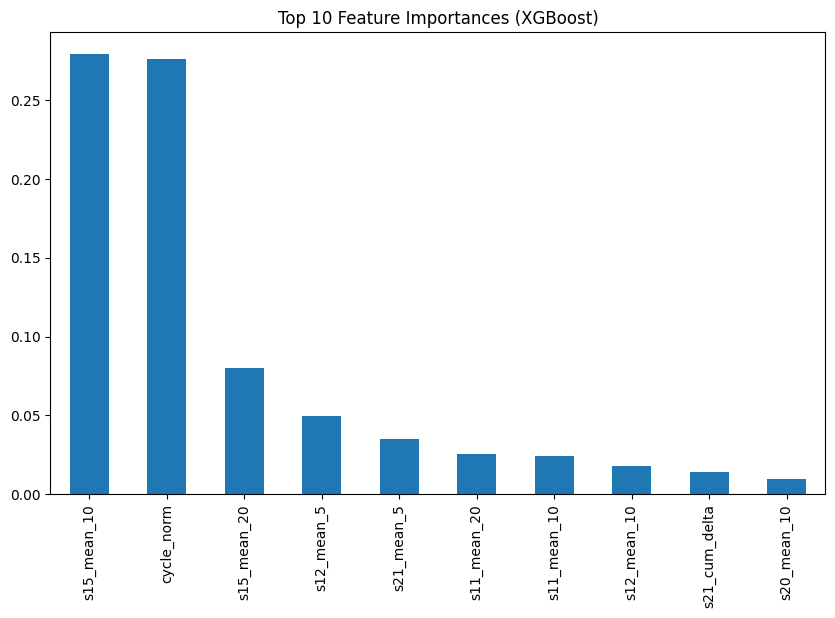

In [54]:
# Feature importance
importances = pd.Series(xgb_model.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances (XGBoost)')
plt.savefig('../results/figures/feature_importances.png')
plt.show()

### Diagnostic Summary

The diagnostic plots reveal that XGBoost predictions collapse toward a
narrow range of values, resulting in large and systematic errors on the
test set.

Error magnitude increases with true RUL, indicating failure to generalize
across different engine lifetimes. Feature importance analysis suggests
over-reliance on lifecycle proxy features rather than stable degradation
signals.

These findings explain the poor test performance and support the selection
of Ridge regression as the final model.


## Model Interpretability with SHAP

SHAP (SHapley Additive exPlanations) is used to analyze feature contributions
for both linear (Ridge) and nonlinear (XGBoost) models.

This helps validate whether learned relationships align with known
degradation mechanisms.


PermutationExplainer explainer: 101it [00:16,  2.34it/s]                         
C:\Users\sarfras\AppData\Local\Temp\ipykernel_22388\2560818010.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


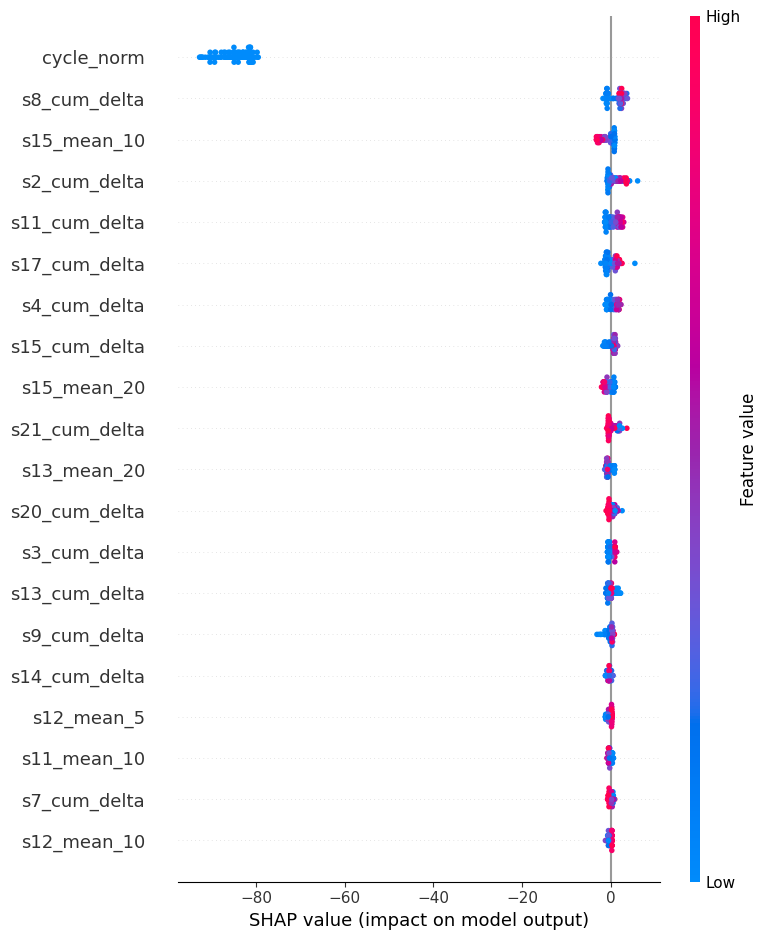

In [55]:
background = X_train.sample(200, random_state=42)

explainer = shap.Explainer(
    xgb_model.predict,
    background
)

shap_values = explainer(X_test)

shap.summary_plot(
    shap_values,
    X_test,
    show=False
)
plt.savefig('../results/figures/shap_summary_xgboost.png', bbox_inches='tight')
plt.show()


### SHAP Interpretation – XGBoost

The SHAP summary plot shows that XGBoost relies heavily on lifecycle-related
features such as normalized cycle position and cumulative sensor deltas.

While these features are predictive within seen engines, their dominance
suggests the model is memorizing engine-specific degradation trajectories
rather than learning generalizable failure patterns.

This over-reliance explains the strong training performance but poor
generalization on unseen test engines.


C:\Users\sarfras\AppData\Local\Temp\ipykernel_22388\4053671880.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


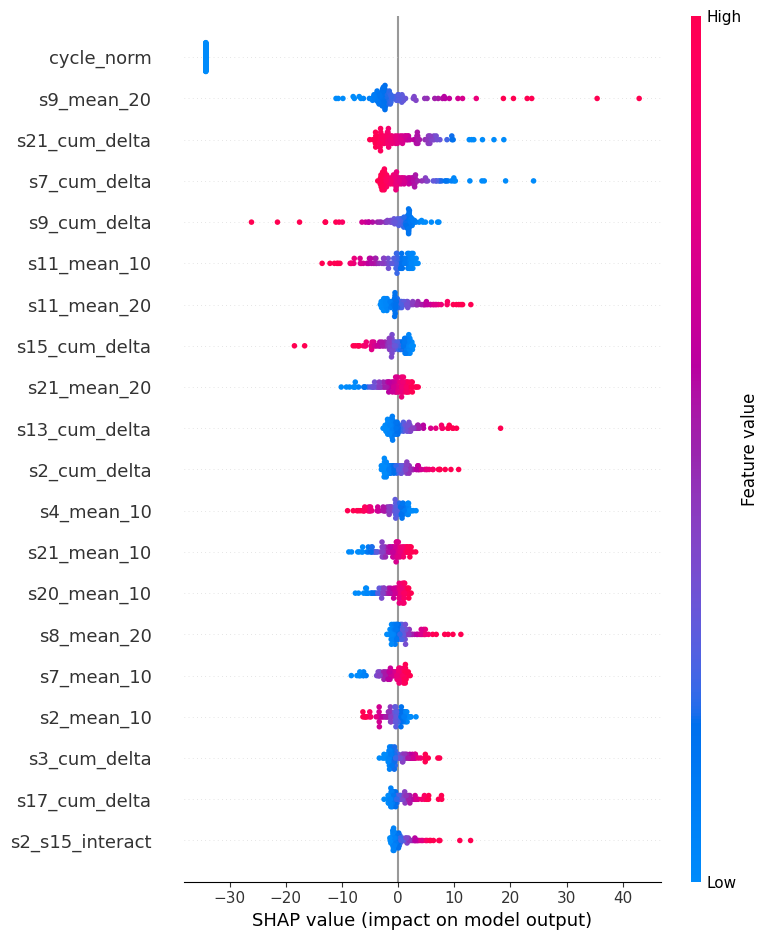

In [57]:
background = X_train.sample(200, random_state=42)

explainer = shap.Explainer(
    ridge.predict,
    background
)

shap_values = explainer(X_test)

shap.summary_plot(
    shap_values,
    X_test,
    show=False
)
plt.savefig('../results/figures/shap_summary_ridge.png', bbox_inches='tight')
plt.show()


### SHAP Interpretation – Ridge Regression

The SHAP summary plot for Ridge regression shows more evenly distributed
feature contributions, with multiple degradation-related features jointly
influencing predictions.

Unlike XGBoost, no single lifecycle proxy dominates the model. This indicates
that Ridge learns stable, additive degradation relationships, which contributes
to its superior generalization on unseen engines.


## Final Model Selection

Based on test performance, stability, and interpretability,
Ridge regression is selected as the final model.

The model is retrained on the full training dataset and saved
for reproducibility and downstream use.


In [61]:
final_model = Ridge(alpha=1.0)
final_model.fit(X_train_full, y_train_full)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [60]:
import joblib
joblib.dump(final_model, "../results/ridge_final.joblib")

['../results/ridge_final.joblib']

In [ ]:
# Load engineered test 
test_df = pd.read_csv('../data/processed/engineered_test.csv')

# Keep last cycle per engine
test_last = test_df.groupby('engine_id').tail(1)

X_test = test_last[feature_cols]
y_test = pd.read_csv('../data/raw/RUL_FD001.txt', header=None)[0].values

# Predict
y_pred = final_model.predict(X_test)

In [63]:
errors = y_test - y_pred

In [64]:
y_true_bin = (y_test <= 30).astype(int)
y_pred_bin = (y_pred <= 30).astype(int)

## Maintenance Threshold Evaluation

To assess practical maintenance usefulness, RUL predictions are
converted into a binary classification task using a 30-cycle threshold.

This evaluates the model’s ability to identify engines nearing failure.


In [65]:
print(precision_score(y_true_bin, y_pred_bin))
print(recall_score(y_true_bin, y_pred_bin))
print(f1_score(y_true_bin, y_pred_bin))

0.9583333333333334
0.92
0.9387755102040817


In [66]:
abs_error = np.abs(errors)

pd.DataFrame({
    'true_rul': y_test,
    'pred_rul': y_pred,
    'abs_error': abs_error
}).describe()

,true_rul,pred_rul,abs_error
count,100.00000,100.000000,100.000000
mean,75.52000,49.119499,28.426237
std,41.76497,23.074369,20.859202
min,7.00000,-17.778130,0.445297
25%,32.75000,32.167684,10.700548
50%,86.00000,57.116459,24.321909
75%,112.25000,67.137965,42.879264
max,145.00000,83.856679,75.240503


In [67]:
coef = pd.Series(
    ridge.coef_,
    index=feature_cols
).sort_values(key=np.abs, ascending=False)

coef.head(10)


cycle_norm    -63.034890
op1            -7.184171
s7_std_20       5.970000
s11_std_20      5.372362
s2_std_20       5.279802
s4_std_20       4.941904
s20_std_20      4.820472
s21_std_20      4.763252
s17_std_20      3.691043
s9_slope_20    -3.393985
dtype: float64